In [2]:
!pip install bert-for-tf2
#!pip install tf-nightly
import tensorflow_hub as hub
import tensorflow as tf
import bert
from bert import bert_tokenization
from tensorflow.keras import layers

FullTokenizer = bert.bert_tokenization.FullTokenizer
import math

     |████████████████████████████████| 40kB 1.8MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.4-cp36-none-any.whl size=30114 sha256=c8815685412dd1ed1d507d9fca4e8b11ce3a14a5540272bf2b6af29441627729
  Stored in directory: /root/.cache/pip/wheels/cf/3f/4d/79d7735015a5f523648df90d871ce8e89a7df8185f7703eeab
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=152f2f2571bcf76fcc2148653b041dd41424aa5b049a285a6afee32ab8de247f
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19473 sha256=229e78e97dd5209dcb7f6bc2582fe0e53d507594a2cc995004bc65845ca5f717
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [3]:
import bert
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from tensorflow.keras import backend as K

In [5]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

df = pd.read_csv('./data/clean_train.csv', index_col = False)
df.dropna(inplace = True)
df.reset_index(drop=True,inplace=True)

In [6]:
X_data = df['text'].to_numpy()
y_data = df['target'].to_numpy()
y_data = y_data.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=777)
class_weights = class_weight.compute_class_weight('balanced', np.unique(df['target'].to_numpy()), df['target'].to_numpy())
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.086939150585321, 1: 0.9259385317041625}


In [7]:
MAX_SEQ_LEN = 65

In [8]:
def bert_encode(texts, tokenizer, sequence_length=512):
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in texts:
        try:
            #print(text) #Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
            text = tokenizer.tokenize(text)
            #print(text) #['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
            #print(len(text)) #14
            text = text[:sequence_length-2]
            #print(len(text)) #14
            #print(text) #['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
            input_sequence = ["[CLS]"] + text + ["[SEP]"]
            #print(input_sequence) #['[CLS]', 'our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all', '[SEP]']
            #print(len(input_sequence)) #16
            pad_len = sequence_length - len(input_sequence)
            tokens = tokenizer.convert_tokens_to_ids(input_sequence)
            #print(tokens) #[101, 2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035, 102]
            #print(len(tokens)) #16
            tokens += [0] * pad_len
            #print(tokens) #[101, 2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
            #print(len(tokens)) #160
            pad_masks = [1] * len(input_sequence) + [0] * pad_len
            #print(pad_masks) #[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
            #print(len(pad_masks)) #160
            segment_ids = [0] * sequence_length
            #print(segment_ids) #[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
            #print(len(segment_ids)) #160

            all_tokens.append(tokens)
            all_masks.append(pad_masks)
            all_segments.append(segment_ids)
        except:
            print(text)
            return 0

    return [np.array(all_tokens, dtype=np.int32), np.array(all_masks, dtype=np.int32), np.array(all_segments, dtype=np.int32)]

In [9]:
base_model = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1')


bert_layer = hub.KerasLayer(base_model)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

In [10]:
X_train_en = bert_encode(X_train, tokenizer=tokenizer, sequence_length=MAX_SEQ_LEN)
X_test_en = bert_encode(X_test, tokenizer=tokenizer, sequence_length=MAX_SEQ_LEN)

In [11]:
cnn_filters = 100
DNN_UNITS = 64
#checkpoint_filepath = './models/cnn_rnn'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='acc',
#     mode='max',
#     save_best_only=True)

input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="input_ids")
input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="input_masks")
input_segment = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="segment_ids")
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_segment])



cnn_l1 =  tf.keras.layers.Conv1D(filters=cnn_filters,kernel_size=2,padding="same",activation="relu")(sequence_output)
lstm1 = tf.keras.layers.LSTM(32, return_state= False)(cnn_l1)
flat1 = tf.keras.layers.Flatten()(lstm1)

cnn_l2 = tf.keras.layers.Conv1D(filters=cnn_filters,kernel_size=3,padding="same",activation="relu")(sequence_output)
lstm2 = tf.keras.layers.LSTM(32, return_state= False)(cnn_l2)
flat2 = tf.keras.layers.Flatten()(lstm2)

cnn_l3 = tf.keras.layers.Conv1D(filters=cnn_filters, kernel_size=4,padding="same",activation="relu")(sequence_output)
lstm3 = tf.keras.layers.LSTM(32, return_state= False)(cnn_l3)
flat3 = tf.keras.layers.Flatten()(lstm3)

concat = tf.concat([flat1, flat2, flat3], axis=-1)
dense_1 = tf.keras.layers.Dense(units=DNN_UNITS, activation="relu")(concat)


pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense_1)

model = tf.keras.models.Model(inputs=[input_word_ids,input_mask,input_segment], outputs=pred)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 65)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 65)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 65)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_ids[0][0]                  
                                                                 input_masks[0][0]            

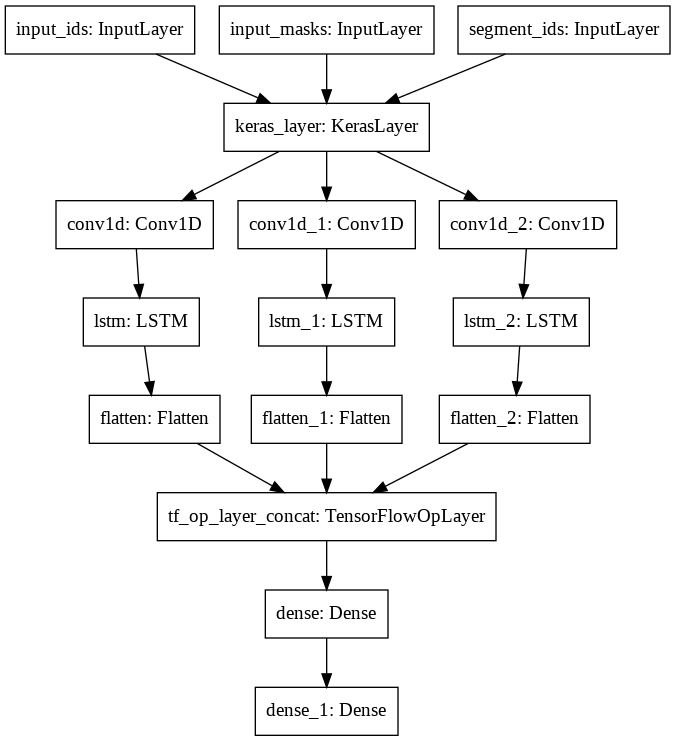

In [13]:
tf.keras.utils.plot_model(model)

In [14]:
model.fit(X_train_en, y_train, class_weight = class_weights, epochs=2, batch_size=32)

Epoch 1/2
1361/1361 [==============================] - 1225s 900ms/step - loss: 0.5593 - accuracy: 0.7081
Epoch 2/2
1361/1361 [==============================] - 1225s 900ms/step - loss: 0.5078 - accuracy: 0.7421


In [15]:
%%time
y_prob = model.predict(X_test_en, verbose = 1)
y_pred = (y_prob > 0.5).astype(int)
print(classification_report(y_test, y_pred, digits = 4))

341/341 [==============================] - 298s 875ms/step
              precision    recall  f1-score   support

           0     0.7030    0.8026    0.7495      5020
           1     0.8076    0.7097    0.7555      5862

    accuracy                         0.7525     10882
   macro avg     0.7553    0.7561    0.7525     10882
weighted avg     0.7594    0.7525    0.7527     10882

CPU times: user 3min 37s, sys: 1min 57s, total: 5min 34s
Wall time: 5min 3s


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


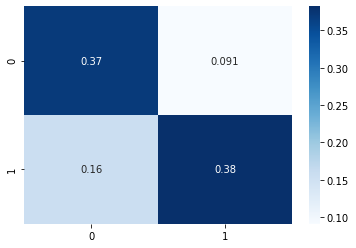

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm/np.sum(cm), annot=True, cmap='Blues')

In [17]:
model.save('./models/cnn_rnn')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./models/cnn_rnn/assets


INFO:tensorflow:Assets written to: ./models/cnn_rnn/assets


# Submit

In [ ]:
new_model = tf.keras.models.load_model('./models/rnn')

In [ ]:
df = pd.read_csv('./data/test_clean.csv', index_col = False)
df['text'] = df['text'].fillna("")

In [ ]:
X_data = df['text'].to_numpy()
X_data_en = bert_encode(X_data, tokenizer=tokenizer, sequence_length=80)

In [ ]:
%%time

y_prob = model.predict(X_data_en, verbose = 1)
y_pred = (y_prob > 0.5).astype(int)

CPU times: user 4min 6s, sys: 3min 22s, total: 7min 29s
Wall time: 19min 12s


In [ ]:
submission = pd.read_csv('./data/sample_submit.csv', index_col = False)

submission["target"] = y_pred

In [ ]:
submission.to_csv("./results/result1.csv", index = False)
submission.head(10)